# Practice PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-11-13</font>

In [1]:
# LEAVE THIS CELL AS-IS

import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

In [2]:
# LEAVE THIS CELL AS-IS
import warnings
warnings.filterwarnings("ignore")
dft = pd.read_csv('annthyroid.csv', sep=',')
dfc = pd.read_csv('cardio.csv', sep=',')

In [3]:
display(dft.head(5))
display(dfc.head(5))

,f1,f2,f3,f4,f5,f6,label
0,0.73,0.00060,0.015,0.120,0.082,0.146,0.0
1,0.24,0.00025,0.030,0.143,0.133,0.108,0.0
2,0.47,0.00190,0.024,0.102,0.131,0.078,0.0
3,0.64,0.00090,0.017,0.077,0.090,0.085,0.0
4,0.23,0.00025,0.026,0.139,0.090,0.153,0.0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,result
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,normal
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,normal
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,normal
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,normal
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,normal


In [4]:
# There is no feature 'result' in the data file annthyroid.csv, so I modified the data
dft['label'] = dft['label'].map({0: 'normal', 1: 'abnormal'})
dft = dft.rename(columns={'label': 'result'})
display(dft)

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...
7195,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


<font size="+1" color="red">Replace this cell with your code to print the number and percentages of patients in each group.</font>

In [5]:
tot_thy = dft['result'].count()
print(f"Thyroid dataset containing {tot_thy} patients")
label_counts = dft['result'].value_counts()
label_ratio = label_counts / tot_thy
# 0 -> normal / 1-> abnormal
print(f"Normal  : {label_counts[0]} ({round(label_ratio[0] * 100, 2)}%)")
print(f"Abormal  : {label_counts[1]} ({round(label_ratio[1] * 100, 2)}%)")

tot_cardio = dfc['result'].count()
print(f"\nCardio dataset containing {tot_cardio} patients")
ret_counts = dfc['result'].value_counts()
ret_ratio = ret_counts / tot_cardio
print(f"Normal  : {ret_counts['normal']} ({round(ret_ratio['normal'] * 100, 2)}%)")
print(f"Abormal  : {ret_counts['abnormal']} ({round(ret_ratio['abnormal'] * 100, 2)}%)")

Thyroid dataset containing 7200 patients
Normal  : 6666 (92.58%)
Abormal  : 534 (7.42%)

Cardio dataset containing 1831 patients
Normal  : 1655 (90.39%)
Abormal  : 176 (9.61%)


## 1.1. Centroid inspection for the "thyroid" dataset

<font size="+1" color="red">Replace this cell with your code to print the 10 normal exams in the `thyroid` dataset and the centroid of all normal exams, and the first 10 abnormal exams and the centroid of all abnormal exams.</font>

In [6]:
# 0 -> normal / 1-> abnormal
# normal = dft[dft['label'] == 0].drop(columns=['label'])
# abnormal = dft[dft['label'] == 1].drop(columns=['label'])
normal = dft[dft['result'] == 'normal'].drop(columns=['result'])
abnormal = dft[dft['result'] == 'abnormal'].drop(columns=['result'])

# centroids
centroid_normal = normal.mean()
centroid_abnormal = abnormal.mean()

print(f"First 10 normal exams:")
display(normal.head(10))
print("\nCentroid (average) of normal exams:")
print(centroid_normal)

print("\nFirst 10 abnormal exams:")
display(abnormal.head(10))
print("\nCentroid (average) of abnormal exams:")
print(centroid_abnormal)

First 10 normal exams:


,f1,f2,f3,f4,f5,f6
0,0.73,0.00060,0.015,0.120,0.082,0.146
1,0.24,0.00025,0.030,0.143,0.133,0.108
2,0.47,0.00190,0.024,0.102,0.131,0.078
3,0.64,0.00090,0.017,0.077,0.090,0.085
4,0.23,0.00025,0.026,0.139,0.090,0.153
5,0.69,0.00025,0.016,0.086,0.070,0.123
6,0.85,0.00025,0.023,0.128,0.104,0.121
7,0.48,0.00208,0.020,0.086,0.078,0.110
8,0.67,0.00130,0.024,0.087,0.109,0.080
9,0.76,0.00010,0.029,0.124,0.128,0.097



Centroid (average) of normal exams:
f1    0.518314
f2    0.002098
f3    0.020384
f4    0.112193
f5    0.097705
f6    0.116132
dtype: float64

First 10 abnormal exams:


,f1,f2,f3,f4,f5,f6
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640



Centroid (average) of abnormal exams:
f1    0.548034
f2    0.039363
f3    0.014891
f4    0.074940
f5    0.099500
f6    0.076803
dtype: float64


<font size="+1" color="red">Replace this cell with a brief comment indicating, based only on the centroids, which features do you think could be useful for differentiating between normal and abnormal thyroids? Why?</font>

#### Comment
Based on the comparison of centroids between normal and abnormal, we can observe there are relatively higher differences on some dimensions/features, e.g. f2, f4, f6, f1, especially f2, which the difference is almost 20 times. f4 is obviously higher in the abnormal than the noral, but f4 and f6 shows the opposite.  f1 is slighterly higher in the abnormal. Hence, we can assume that with these features, we could diffenrentiate between normal and abnormal thyroids.

## 1.2. Scatter plot inspection for the "cardio" dataset 

<font size="+1" color="red">Replace this cell with your code to create a scatter matrix as described above.</font>

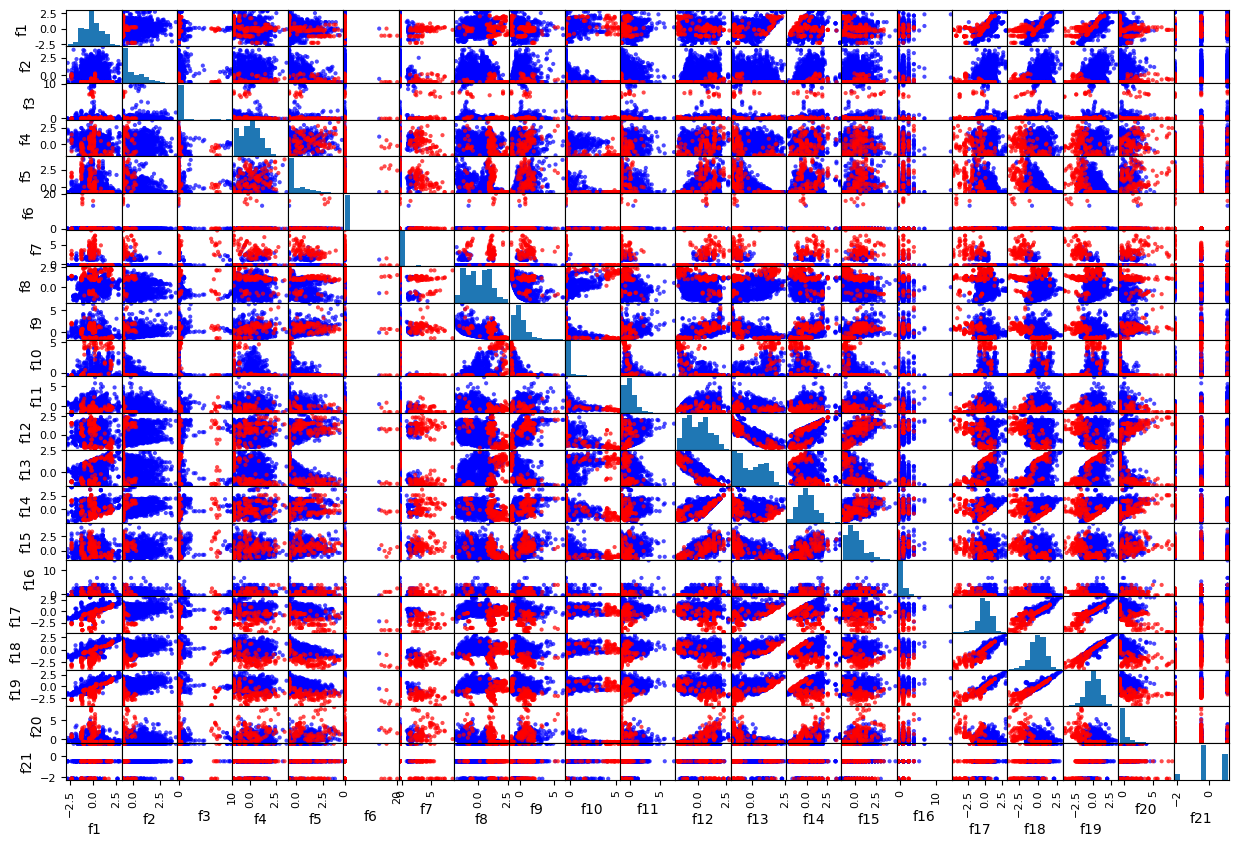

In [44]:
color_code = {'abnormal': 'red', 'normal': 'blue'}
colors = dfc['result'].apply(lambda x: color_code[x])
# pd.plotting.scatter_matrix(dfc, c = colors, figsize=(15, 10))
pd.plotting.scatter_matrix(
    dfc.drop(columns=['result']),  
    c=colors,
    figsize=(15, 10),
    alpha=0.7,  
    diagonal='hist'  
)
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary on whether you already guess any difference between normal and abnormal exams, based on combinations of features. What are the differences you can appreciate?</font>

#### Comment
From the observation of the scatter matrix, f2 in combination with most other features can effectively distinguish between normal and abnormal samples. Although the diagonal histograms do not show class information, in the off-diagonal scatter plots, abnormal samples (red) are concentrated in the high-value region of f2, while normal samples (blue) are mostly clustered in the low-value region of f2. Therefore, f2 is the most important discriminative feature, and other features in combination with f2 also contribute to distinguishing the classes. 

# 1. Create isolation tree

## 1.1. Random dimension and random split

<font size="+1" color="red">Replace this cell with code implementing "pick_random_dimension".

In [8]:
def pick_random_dimension(df, columns_to_ignore):
    df_new = df.drop(columns = columns_to_ignore)
    num_cols = df_new.shape[1]
    idx = random.randint(0, num_cols - 1)
    return df_new.columns[idx]

In [9]:
# LEAVE THIS CODE AS-IS
# Testing code

print("Random dimensions for the 'thyroid' dataset")
print(pick_random_dimension(dft, ["result"]))
print(pick_random_dimension(dft, ["result"]))
print()

print("Random dimensions for the 'cardio' dataset")
print(pick_random_dimension(dfc, ["result"]))
print(pick_random_dimension(dfc, ["result"]))

Random dimensions for the 'thyroid' dataset
f6
f4

Random dimensions for the 'cardio' dataset
f13
f14


<font size="+1" color="red">Replace this cell with code implementing "pick_random_split" and a couple of calls to test this function; each call should return a random split point chosen uniformly at random between the minimum and the maximum value along a dimension.</font>

In [10]:
def pick_random_split(df, dimension):
    lo = np.min(df[dimension])
    hi = np.max(df[dimension])
    return np.random.uniform(lo, hi)

In [11]:
# LEAVE THIS CODE AS-IS

print("Random splits according to 'f4' in the 'thyroid' dataset")
print(pick_random_split(dft, "f4"))
print(pick_random_split(dft, "f4"))
print()
print("Random splits according to 'f15' in the 'cardio' dataset")
print(pick_random_split(dfc, "f15"))
print(pick_random_split(dfc, "f15"))

Random splits according to 'f4' in the 'thyroid' dataset
0.4549210268384893
0.1745093128442689

Random splits according to 'f15' in the 'cardio' dataset
1.843974379440317
0.32126433456092585


## 1.2. Implement split data into two

<font size="+1" color="red">Replace this cell with code implementing "split_dataset".</font>

In [12]:
def split_dataset(df, dimension, split):
    left = df[df[dimension] <= split]
    right = df[df[dimension] > split]
    return left, right

<font size="+1" color="red">Replace this cell with code testing "split_dataset", i.e., select a dataset, a dimension, and a cut-off, and split the dataset, then print the two pieces and check that it is working correctly. Also check that the sum of the sizes of the two pieces is the size of the original data.</font>

In [13]:
print("Random splits according to 'f1' in the 'thyroid' dataset")
split = pick_random_split(dft, "f1")
left, right = split_dataset(dft, "f1", split)
print(f"Split value: {split:.4f}")
print("Left subset:\n", left)
print("\nRight subset:\n", right)
assert((len(left) + len(right) == len(dft['f1'])))


print("\n")
print("Random splits according to 'f20' in the 'cardio' dataset")
split2 = pick_random_split(dfc, "f20")
left2, right2 = split_dataset(dfc, "f20", split2)
print(f"Split value: {split2:.4f}")
print("left subset:\n", left2)
print("right subset:\n", right2)
assert((len(left2) + len(right2) == len(dfc['f20'])))

Random splits according to 'f1' in the 'thyroid' dataset
Split value: 0.2238
Left subset:
         f1       f2      f3       f4     f5       f6  result
11    0.18  0.00010  0.0230  0.09800  0.085  0.11500  normal
32    0.22  0.00050  0.0170  0.08300  0.086  0.09700  normal
33    0.22  0.00090  0.0250  0.11000  0.100  0.11000  normal
40    0.20  0.00189  0.0206  0.11118  0.099  0.11207  normal
82    0.16  0.00005  0.0620  0.25500  0.104  0.24400  normal
...    ...      ...     ...      ...    ...      ...     ...
7061  0.08  0.00929  0.0240  0.12600  0.096  0.13100  normal
7104  0.18  0.00208  0.0201  0.14300  0.096  0.14864  normal
7126  0.15  0.00480  0.0201  0.06900  0.102  0.06800  normal
7140  0.17  0.00130  0.0201  0.07400  0.077  0.09600  normal
7147  0.22  0.00260  0.0110  0.11900  0.088  0.13500  normal

[493 rows x 7 columns]

Right subset:
         f1       f2      f3     f4     f5      f6    result
0     0.73  0.00060  0.0150  0.120  0.082  0.1460    normal
1     0.24  0.000

## 1.3. Create one isolation tree

In [14]:
# LEAVE THIS COLUMN AS-IS

dfti = dft.copy()
dfti.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(dft))])
display(dfti.head(5))

dfci = dfc.copy()
dfci.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(dfc))])
display(dfci.head(5))

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,P0002,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,P0003,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,P0004,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,P0005,0.23,0.00025,0.026,0.139,0.090,0.153,normal


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,result
0,P0001,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,normal
1,P0002,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,normal
2,P0003,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,normal
3,P0004,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,normal
4,P0005,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,normal


<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

In [15]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # REPLACE WITH YOUR CODE 
        dimension = pick_random_dimension(data, columns_to_ignore)
        split = pick_random_split(data, dimension)
        left, right = split_dataset(data, dimension, split)
        tree["dimension"] = dimension
        tree["split"] = split
        tree["left"] = isolation_tree(left, columns_to_ignore, min_items)
        tree["right"] = isolation_tree(right, columns_to_ignore, min_items)
        return tree

In [16]:
# LEAVE THIS CODE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [17]:
# LEAVE THIS CODE AS-IS

mytree_thyroid = isolation_tree(dfti, ['id', 'result'], 2000)
mytree_cardio = isolation_tree(dfci, ['id', 'result'], 200)

In [18]:
# LEAVE THIS CODE AS-IS

print("Tree built on the 'thyroid' dataset")
print(tree_to_nodes(mytree_thyroid))
print()

print("Tree built on the 'cardio' dataset")
print(tree_to_nodes(mytree_cardio))
print()

Tree built on the 'thyroid' dataset
:'internal node: f1 <= 0.94'
-<:'internal node: f5 <= 0.06'
--<:'external node: 64 normal + 1 abnormal'
-->:'internal node: f3 <= 0.03'
---<:'internal node: f1 <= 0.13'
----<:'external node: 47 normal + 8 abnormal'
---->:'internal node: f1 <= 0.58'
-----<:'internal node: f1 <= 0.32'
------<:'external node: 916 normal + 57 abnormal'
------>:'internal node: f5 <= 0.13'
-------<:'internal node: f6 <= 0.27'
--------<:'internal node: f2 <= 0.09'
---------<:'internal node: f5 <= 0.10'
----------<:'external node: 1222 normal + 80 abnormal'
---------->:'external node: 868 normal + 68 abnormal'
--------->:'external node: 2 normal + 17 abnormal'
-------->:'external node: 5 normal + 0 abnormal'
------->:'external node: 83 normal + 6 abnormal'
----->:'internal node: f3 <= 0.02'
------<:'external node: 1217 normal + 239 abnormal'
------>:'external node: 1414 normal + 37 abnormal'
--->:'external node: 820 normal + 21 abnormal'
->:'external node: 8 normal + 0 abnor

<font size="+1" color="red">Replace this cell with you code implementing `get_max_tree_depth`</font>

In [19]:
def get_max_tree_depth(tree):
    if 'contents' in tree:
        return 1
    left_depth = get_max_tree_depth(tree['left'])
    right_depth = get_max_tree_depth(tree['right'])
    return 1 + max(left_depth, right_depth)

In [20]:
# LEAVE THIS CODE AS-IS
# Testing code

print("Depth of the random tree you built over the 'thyroid' dataset")
print(get_max_tree_depth(mytree_thyroid))
print()

print("Depth of the random tree you built over the 'cardio' dataset")
print(get_max_tree_depth(mytree_cardio))
print()

Depth of the random tree you built over the 'thyroid' dataset
11

Depth of the random tree you built over the 'cardio' dataset
19



# 2. Create isolation forests and find depth of items

## 2.1. Create an isolation forest

<font size="+1" color="red">Replace this cell with you code implementing "isolation_tree".</font>

In [21]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    forest = []
    for _ in range(num_trees):
        tree = isolation_tree(df, columns_to_ignore, min_items)
        forest.append(tree)
    return forest

In [22]:
# LEAVE AS-IS OR MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES
# If you change 'min_items' or 'num_trees', indicate here that you have changed them

min_items_thyroid = 50
num_trees_thyroid = 20

myforest_thyroid = isolation_forest(dfti, ['id', 'result'], min_items_thyroid, num_trees_thyroid)
print("The 'thyroid' forest has %d trees" % len(myforest_thyroid))

min_items_cardio = 50
num_trees_cardio = 20

myforest_cardio = isolation_forest(dfci, ['id', 'result'], min_items_cardio, num_trees_cardio)
print("The 'cardio' forest has %d trees" % len(myforest_cardio))

The 'thyroid' forest has 20 trees
The 'cardio' forest has 20 trees


In [23]:
# LEAVE THIS CODE AS-IS

print("Thyroid forest (first two trees)")
print(tree_to_nodes(myforest_thyroid[0]))
print(tree_to_nodes(myforest_thyroid[1]))
print()

print("Cardio forest (first two trees)")
print(tree_to_nodes(myforest_cardio[0]))
print(tree_to_nodes(myforest_cardio[1]))
print()


Thyroid forest (first two trees)
:'internal node: f1 <= 0.78'
-<:'internal node: f1 <= 0.28'
--<:'internal node: f4 <= 0.26'
---<:'internal node: f5 <= 0.19'
----<:'internal node: f2 <= 0.39'
-----<:'internal node: f5 <= 0.17'
------<:'internal node: f1 <= 0.01'
-------<:'external node: 5 normal + 5 abnormal'
------->:'internal node: f5 <= 0.06'
--------<:'external node: 7 normal + 0 abnormal'
-------->:'internal node: f4 <= 0.04'
---------<:'external node: 7 normal + 7 abnormal'
--------->:'internal node: f5 <= 0.17'
----------<:'internal node: f3 <= 0.02'
-----------<:'internal node: f5 <= 0.07'
------------<:'external node: 23 normal + 0 abnormal'
------------>:'internal node: f1 <= 0.22'
-------------<:'internal node: f2 <= 0.15'
--------------<:'internal node: f6 <= 0.15'
---------------<:'internal node: f5 <= 0.08'
----------------<:'external node: 18 normal + 0 abnormal'
---------------->:'internal node: f6 <= 0.09'
-----------------<:'external node: 32 normal + 5 abnormal'
----

## 2.2. Find the average depth of an item

In [24]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [25]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("Shallow tree for thyroid, having maximum depth %d" % get_max_tree_depth(mytree_thyroid))
print_sample_depths(dfti, 5, mytree_thyroid)
print()

print("Shallow tree for cardio, having maximum depth %d" % get_max_tree_depth(mytree_cardio))
print_sample_depths(dfci, 5, mytree_cardio)
print()

Shallow tree for thyroid, having maximum depth 11
Depths for normal items
- id=P3882 is at depth 6/11
- id=P1459 is at depth 6/11
- id=P7191 is at depth 6/11
- id=P2356 is at depth 10/11
- id=P1092 is at depth 3/11
Depths for abnormal items
- id=P3676 is at depth 10/11
- id=P5463 is at depth 10/11
- id=P5234 is at depth 6/11
- id=P1556 is at depth 6/11
- id=P3755 is at depth 6/11

Shallow tree for cardio, having maximum depth 19
Depths for normal items
- id=P1231 is at depth 6/19
- id=P0579 is at depth 12/19
- id=P1528 is at depth 6/19
- id=P1182 is at depth 12/19
- id=P1064 is at depth 6/19
Depths for abnormal items
- id=P1721 is at depth 6/19
- id=P1707 is at depth 18/19
- id=P1683 is at depth 8/19
- id=P1722 is at depth 6/19
- id=P1660 is at depth 18/19



<font size="+1" color="red">Replace this cell with a brief commentary on these depths.</font>

<font size="+1" color="red">Replace this cell with you code implementing "find_average_depth".</font>

In [41]:
def find_average_depth(forest, column_name, value):
    # n = len(forest)
    tot_depth = 0
    count = 0
    for tree in forest:
        depth = find_element_depth(tree, column_name, value)
        if depth is None:
            continue
        tot_depth += depth
        count += 1
    if count == 0:
        return None
    
    return tot_depth / count

In [42]:
# LEAVE AS-IS

def test_random_elements(df, forest):
    for result in ['normal', 'abnormal']:
        print("Average depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(5))

        for random_id in sample:
            print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(forest, "id", random_id)))

        print()
        
print("Testing forest for the 'thyroid' dataset")
test_random_elements(dfti, myforest_thyroid)
print()

print("Testing forest for the 'cardio' dataset")
test_random_elements(dfti, myforest_thyroid)
print()



Testing forest for the 'thyroid' dataset
Average depths for normal items
- id=P2143 is at average depth 25.5
- id=P5316 is at average depth 16.2
- id=P4684 is at average depth 18.1
- id=P1071 is at average depth 22.1
- id=P5195 is at average depth 22.4

Average depths for abnormal items
- id=P4268 is at average depth 14.4
- id=P4339 is at average depth 19.4
- id=P0921 is at average depth 16.9
- id=P2504 is at average depth 4.0
- id=P2040 is at average depth 13.3


Testing forest for the 'cardio' dataset
Average depths for normal items
- id=P3037 is at average depth 29.0
- id=P2183 is at average depth 20.2
- id=P0163 is at average depth 21.9
- id=P3378 is at average depth 15.1
- id=P3826 is at average depth 25.6

Average depths for abnormal items
- id=P1337 is at average depth 6.0
- id=P5533 is at average depth 18.2
- id=P2453 is at average depth 20.1
- id=P5708 is at average depth 12.5
- id=P0936 is at average depth 14.4




<font size="+1" color="red">Replace this cell with a brief commentary indicating how would you make the "find_average_depth" function more efficient if you wanted to obtain the average depth of **all** elements. Be concise but be precise, providing pseudocode if you consider it clearer than a text explanation.</font>

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [28]:
# LEAVE AS-IS

SAMPLE_SIZE = 30

print("Thyroid dataset")
abnormal_thyroid_sample = list(dfti[dfti['result'] == 'abnormal']['id'].sample(SAMPLE_SIZE))
normal_thyroid_sample = list(dfti[dfti['result'] == 'normal']['id'].sample(SAMPLE_SIZE))
print("Normal point sample ids   : %s" % normal_thyroid_sample)
print("Abnormal point sample ids : %s" % abnormal_thyroid_sample)

print()

print("Cardio dataset")
abnormal_cardio_sample = list(dfci[dfci['result'] == 'abnormal']['id'].sample(SAMPLE_SIZE))
normal_cardio_sample = list(dfci[dfci['result'] == 'normal']['id'].sample(SAMPLE_SIZE))
print("Normal point sample ids   : %s" % normal_cardio_sample)
print("Abnormal point sample ids : %s" % abnormal_cardio_sample)


Thyroid dataset
Normal point sample ids   : ['P0222', 'P3396', 'P6561', 'P3742', 'P5802', 'P4266', 'P0711', 'P7021', 'P0997', 'P3299', 'P2797', 'P4416', 'P0233', 'P3928', 'P5373', 'P3904', 'P0330', 'P6939', 'P4041', 'P7000', 'P4053', 'P4332', 'P2901', 'P5428', 'P5153', 'P6658', 'P3604', 'P5699', 'P4010', 'P2359']
Abnormal point sample ids : ['P2942', 'P0778', 'P3436', 'P4339', 'P5281', 'P1943', 'P2132', 'P1421', 'P5531', 'P6739', 'P4625', 'P2453', 'P5957', 'P6627', 'P7118', 'P2217', 'P1628', 'P3597', 'P1583', 'P5708', 'P1406', 'P3011', 'P5258', 'P6198', 'P4741', 'P6704', 'P5619', 'P5155', 'P3898', 'P5612']

Cardio dataset
Normal point sample ids   : ['P0369', 'P0317', 'P1301', 'P1570', 'P1156', 'P1548', 'P0697', 'P0518', 'P0735', 'P0699', 'P1004', 'P0631', 'P0370', 'P0643', 'P0441', 'P1305', 'P0993', 'P0170', 'P1082', 'P1322', 'P0710', 'P0143', 'P0979', 'P0261', 'P1612', 'P1519', 'P0773', 'P1202', 'P1504', 'P0049']
Abnormal point sample ids : ['P1680', 'P1798', 'P1751', 'P1699', 'P1789

In [29]:
# LEAVE AS-IS

def print_average_depths(forest, sample):
    depths = []
    for i in sample:
        depth = find_average_depth(forest, 'id', i)
        depths.append(depth)
        print(" element id=%s is at average depth %2.f" % (i, depth))
    return depths

print("THYROID dataset")
print("Depths of items in the 'normal' sample:")
normal_depths_thyroid = print_average_depths(myforest_thyroid, normal_thyroid_sample)
print("Depths of items in the 'abnormal' sample:")
abnormal_depths_thyroid = print_average_depths(myforest_thyroid, abnormal_thyroid_sample)
print()

print("CARDIO dataset")
print("Depths of items in the 'normal' sample:")
normal_depths_cardio = print_average_depths(myforest_cardio, normal_cardio_sample)
print("Depths of items in the 'abnormal' sample:")
abnormal_depths_cardio = print_average_depths(myforest_cardio, abnormal_cardio_sample)
print()


THYROID dataset
Depths of items in the 'normal' sample:
 element id=P0222 is at average depth 21
 element id=P3396 is at average depth 21
 element id=P6561 is at average depth 23
 element id=P3742 is at average depth 23
 element id=P5802 is at average depth 24
 element id=P4266 is at average depth 22
 element id=P0711 is at average depth 23
 element id=P7021 is at average depth 20
 element id=P0997 is at average depth 15
 element id=P3299 is at average depth 22
 element id=P2797 is at average depth 23
 element id=P4416 is at average depth 17
 element id=P0233 is at average depth 16
 element id=P3928 is at average depth 23
 element id=P5373 is at average depth 17
 element id=P3904 is at average depth 24
 element id=P0330 is at average depth 21
 element id=P6939 is at average depth 25
 element id=P4041 is at average depth 19
 element id=P7000 is at average depth 13
 element id=P4053 is at average depth 13
 element id=P4332 is at average depth 25
 element id=P2901 is at average depth 20
 

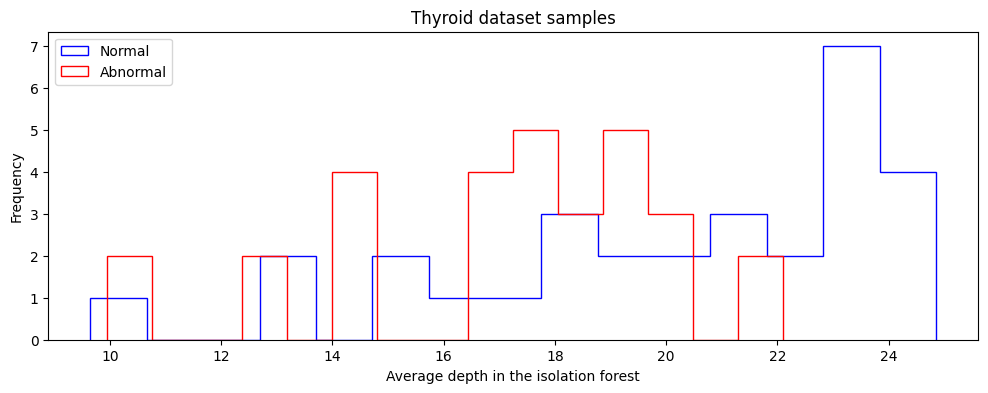

In [30]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths_thyroid, label='Normal', bins=15, density=False, histtype='step', color='blue')
plt.hist(abnormal_depths_thyroid, label='Abnormal', bins=15, density=False, histtype='step', color='red')
plt.title('Thyroid dataset samples')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

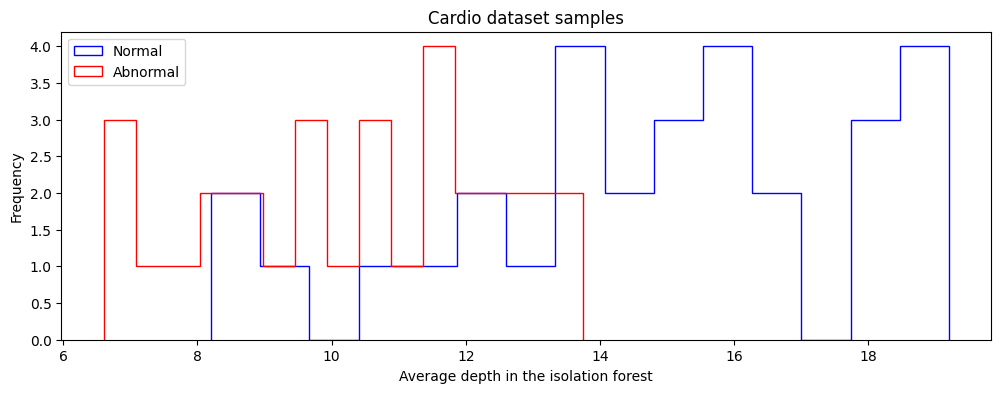

In [31]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths_cardio, label='Normal', bins=15, density=False, histtype='step', color='blue')
plt.hist(abnormal_depths_cardio, label='Abnormal', bins=15, density=False, histtype='step', color='red')
plt.title('Cardio dataset samples')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in these histograms.</font>

## 3.2. Compute outlier scores and conclude

In [32]:
# LEAVE THIS CODE AS-IS
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [33]:
# LEAVE THIS CODE AS-IS

def outlier_score_factory(df):
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score_thyroid = outlier_score_factory(dfti)
outlier_score_cardio = outlier_score_factory(dfci)

# # Compute the scores for thyroid
# normal_scores_thyroid = [outlier_score(d) for d in normal_depths_thyroid]
# abnormal_scores_thyroid = [outlier_score(d) for d in abnormal_depths_thyroid]

# # Compute the scores for cardio
# normal_scores_cardio = [outlier_score(d) for d in normal_depths_cardio]
# abnormal_scores_cardio = [outlier_score(d) for d in abnormal_depths_cardio]

# Compute the scores for thyroid
normal_scores_thyroid = [outlier_score_thyroid(d) for d in normal_depths_thyroid]
abnormal_scores_thyroid = [outlier_score_thyroid(d) for d in abnormal_depths_thyroid]

# Compute the scores for cardio
normal_scores_cardio = [outlier_score_cardio(d) for d in normal_depths_cardio]
abnormal_scores_cardio = [outlier_score_cardio(d) for d in abnormal_depths_cardio]


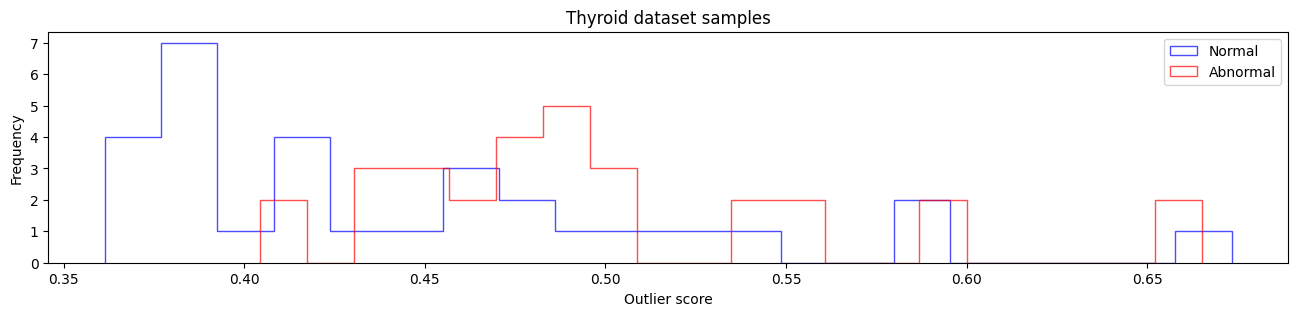

In [34]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores_thyroid, label='Normal', bins=20, density=False, histtype='step', color='blue', alpha=0.7)
plt.hist(abnormal_scores_thyroid, label='Abnormal', bins=20, density=False, histtype='step', color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.title("Thyroid dataset samples")
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

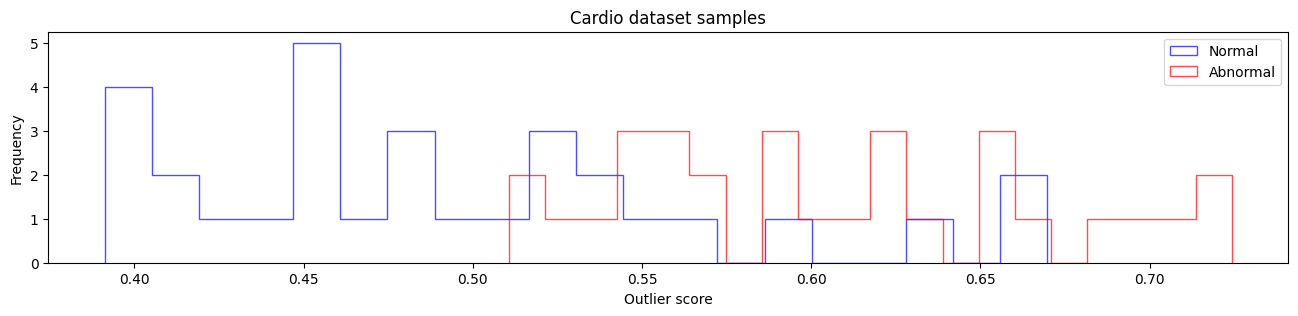

In [35]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores_cardio, label='Normal', bins=20, density=False, histtype='step', color='blue', alpha=0.7)
plt.hist(abnormal_scores_cardio, label='Abnormal', bins=20, density=False, histtype='step', color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.title("Cardio dataset samples")
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary of what you see in these histogram.</font>

<font size="+1" color="red">Replace this cell with your code to determine an optimal threshold for the `thyroid` dataset and the optional threshold for the `cardio` dataset. Indicate clearly what you are trying to do (binary search, exhaustive search, random search, etc.)</font>

In [ ]:
# I choose to use exhaustive search

# Function to compute accuracy
# def compute_accuracy(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     return np.sum(y_true == y_pred) / len(y_true)
def compute_confusion_rates(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==0) & (y_pred==0))
    FP = np.sum((y_true==0) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==0))
    
    accuracy = (TP + TN) / len(y_true)
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    
    return accuracy, FPR, FNR


def threshold_exhaustive_search(scores, labels, candidates):
    """
    scores: array-like, outlier scores
    labels: array-like, true labels (0=normal, 1=abnormal)
    candidates: array of threshold candidates 
    return: threshold and its accuracy
    """
    best_acc = -1
    best_threshold = None
    best_fpr = None
    best_fnr = None
    
    for t in candidates:
        preds = (scores > t).astype(int)  
        acc, fpr, fnr = compute_confusion_rates(labels, preds)
        if acc > best_acc:
            best_acc = round(acc, 4)
            best_threshold = round(t, 4)
            best_fpr = round(fpr, 4)
            best_fnr = round(fnr, 4)
            
    return best_threshold, best_acc, best_fpr, best_fnr

<font size="+1" color="red">Replace this cell with your evaluation (accuracy, false positive rate, and false negative rate) of the optimal threshold of outlier score for the `thyroid` dataset and for the `cardio` dataset, separately. Include a brief commentary, in your own words, on how this method performs on both datasets.</font>

In [37]:
# Evaluate thyroid thresholds
sample_ids_thyroid = abnormal_thyroid_sample + normal_thyroid_sample
label_thyroid = dfti.set_index('id').loc[sample_ids_thyroid, 'result'].map({'normal':0,'abnormal':1}).to_numpy()
scores_thyroid = np.array(abnormal_scores_thyroid + normal_scores_thyroid)
candidates_thyroid = np.linspace(min(scores_thyroid), max(scores_thyroid), 1000)

best_t, acc_t, fpr_t, fnr_t = threshold_exhaustive_search(scores_thyroid, label_thyroid, candidates_thyroid)
print("Best threshold for thyroid:", best_t)
print("Accuracy:", acc_t)
print("False Positive Rate:", fpr_t)
print("False Negative Rate:", fnr_t)
label_cardio = dfc['result'].map({'normal': 0, 'abnormal': 1})


# Evaluate cardio thresholds
sample_ids_cardio = abnormal_cardio_sample + normal_cardio_sample
label_cardio = dfci.set_index('id').loc[sample_ids_cardio, 'result'].map({'normal':0,'abnormal':1}).to_numpy()
scores_cardio = np.array(abnormal_scores_cardio + normal_scores_cardio)
candidates_cardio = np.linspace(min(scores_cardio), max(scores_cardio), 1000)

best_c, acc_c, fpr_c, fnr_c = threshold_exhaustive_search(scores_cardio, label_cardio, candidates_cardio)
print("\nBest threshold for cardio:", best_c)
print("Accuracy:", acc_c)
print("False Positive Rate:", fpr_c)
print("False Negative Rate:", fnr_c)


Best threshold for thyroid: 0.4347
Accuracy: 0.75
False Positive Rate: 0.4333
False Negative Rate: 0.0667

Best threshold for cardio: 0.5296
Accuracy: 0.8333
False Positive Rate: 0.2667
False Negative Rate: 0.0667


<font size="+2" color="red">Additional results: faster method to find all depths</font>

The method applied to speed up finding the average depth is cache, which precomputes the depth of each element in every tree and stores it in a dictionary, allowing subsequent queries for any element’s average depth across the forest to be retrieved directly without repeated recursion.

In [38]:
def cache_tree_depths(tree, column_name):
    """
    tree: a isolation_tree
    column_name: column whose depth to be searched
    Return: a dictionary：{element_value: depth}
    """
    cache = {}
    stack = [(tree, 0)]  # (node, depth)

    while stack:
        node, depth = stack.pop()
        if 'contents' in node:
            data = node['contents']
            for val in data[column_name]:
                cache[val] = depth
        else:
            if 'left' in node:
                stack.append((node['left'], depth + 1))
            if 'right' in node:
                stack.append((node['right'], depth + 1))
    return cache


def find_average_depth_from_cache(forest_cache, value):
    '''
    forest_cache: list of dict，each dict is a cache of tree: {element: depth}
    value: element to be searched
    Return: average depth of the element in the forest
    '''
    depths = []
    for cache in forest_cache:
        if value in cache:
            depths.append(cache[value])
    if not depths:
        return None
    return sum(depths) / len(depths)

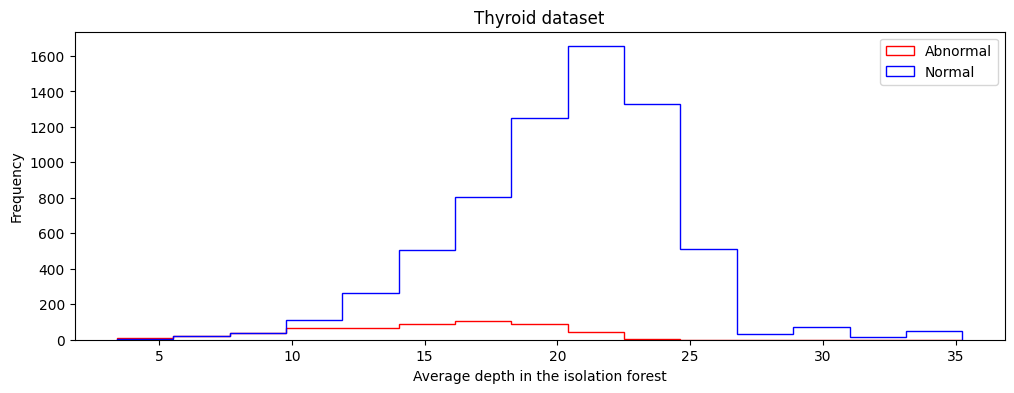

In [39]:
# Normal & abnormal from all dataset thyroid
abnormal_thyroid = list(dfti[dfti['result'] == 'abnormal']['id'])
normal_thyroid = list(dfti[dfti['result'] == 'normal']['id'])

# Caches 
forest_cache_thyroid = [cache_tree_depths(tree, 'id') for tree in myforest_thyroid]

# Average depths
normal_depths_thyroid = [find_average_depth_from_cache(forest_cache_thyroid, i) for i in normal_thyroid]
abnormal_depths_thyroid = [find_average_depth_from_cache(forest_cache_thyroid, i) for i in abnormal_thyroid]

plt.figure(figsize=(12,4))
plt.hist([normal_depths_thyroid, abnormal_depths_thyroid],
         label=['Normal','Abnormal'], bins=15, density=False, histtype='step', color=['blue','red'])
plt.title('Thyroid dataset')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()


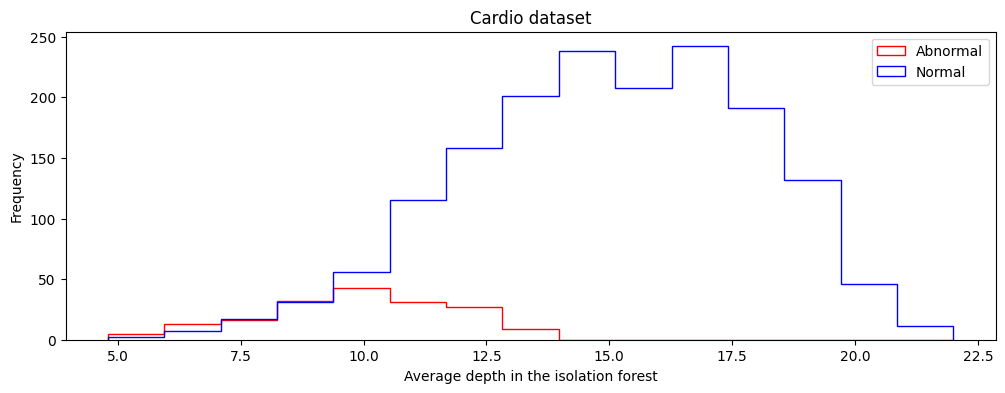

In [40]:
# Normal & abnormal from all dataset cardio
abnormal_cardio = list(dfci[dfci['result'] == 'abnormal']['id'])
normal_cardio = list(dfci[dfci['result'] == 'normal']['id'])

# 
forest_cache_cardio  = [cache_tree_depths(tree, 'id') for tree in myforest_cardio]


# Average depths
normal_depths_cardio = [find_average_depth_from_cache(forest_cache_cardio, i) for i in normal_cardio]
abnormal_depths_cardio = [find_average_depth_from_cache(forest_cache_cardio, i) for i in abnormal_cardio]

plt.figure(figsize=(12,4))
plt.hist([normal_depths_cardio, abnormal_depths_cardio],
         label=['Normal','Abnormal'], bins=15, density=False, histtype='step', color=['blue','red'])
plt.title('Cardio dataset')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>